In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
# from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from imblearn.over_sampling import SMOTE

# sklearn.set_config(transform_output="pandas")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
flight_data_train = pd.read_csv('./flight_data_train.csv')
flight_data_test = pd.read_csv('./flight_data_test.csv')

In [4]:
flight_data_train['scheduledoffblocktime'] = pd.to_datetime(flight_data_train['scheduledoffblocktime'])
flight_data_test['scheduledoffblocktime'] = pd.to_datetime(flight_data_test['scheduledoffblocktime'])

In [5]:
departdatetime = flight_data_train['scheduledoffblocktime'].dt

flight_data_train['depart_day'] = departdatetime.day
flight_data_train['depart_month'] = departdatetime.month
# flight_data_train['depart_year'] = departdatetime.year
flight_data_train['depart_dayofweek'] = departdatetime.dayofweek
flight_data_train['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute
# Test
departdatetime = flight_data_test['scheduledoffblocktime'].dt
flight_data_test['depart_day'] = departdatetime.day
flight_data_test['depart_month'] = departdatetime.month
# flight_data_test['depart_year'] = departdatetime.year
flight_data_test['depart_dayofweek'] = departdatetime.dayofweek
flight_data_test['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute

flight_data_train.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)
flight_data_test.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)

In [6]:
X_train = flight_data_train.drop(columns=['finalflightstatus', 'delay_in_secs'], axis=1)
X_test = flight_data_test.drop(columns=['finalflightstatus', 'delay_in_secs'], axis=1)

y_train_cls = flight_data_train['finalflightstatus']
y_test_cls = flight_data_test['finalflightstatus']
y_train_reg = flight_data_train['delay_in_secs']
y_test_reg = flight_data_test['delay_in_secs']

In [7]:
y_train_cls = y_train_cls.map({'On-Time': 0, 'Delayed':1})
y_test_cls = y_test_cls.map({'On-Time': 0, 'Delayed':1})

In [8]:
X_train

,traffictypecode,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,aircraftterminal,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyc1,skyc2,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute
0,PS,FZ,CMB,7S8,0,F6,2,86.0,57.2,37.62,120.0,5.0,0.0,29.77,4.97,0,NSC,CAVOK,0.0,0.0,29,4,4,210
1,PS,EK,CAI,77W,0,B19,3,98.6,71.6,42.04,60.0,3.0,0.0,29.50,6.21,0,CAVOK,CAVOK,0.0,0.0,11,9,5,1315
2,PS,XY,RUH,32N,0,D11,1,100.4,64.4,31.07,330.0,14.0,0.0,29.53,6.21,0,CAVOK,CAVOK,0.0,0.0,6,6,0,975
3,PS,EK,DAC,77W,0,B6,3,75.2,60.8,60.90,240.0,3.0,0.0,30.12,4.97,0,FEW,CAVOK,4500.0,0.0,12,12,6,630
4,PS,EK,COK,77W,0,B32,3,73.4,55.4,53.29,360.0,2.0,0.0,30.03,6.21,0,CAVOK,CAVOK,0.0,0.0,30,1,5,1305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152635,PS,RA,KTM,332,0,F5,2,69.8,62.6,77.90,100.0,10.0,0.0,30.00,4.97,1,BKN,FEW,4500.0,5000.0,1,1,5,265
152636,PS,FZ,DMM,7M8,0,F8,2,86.0,46.4,25.26,90.0,5.0,0.0,30.03,6.21,0,CAVOK,CAVOK,0.0,0.0,22,11,0,650
152637,PS,EK,KWI,77W,0,B14,3,77.0,51.8,41.42,320.0,4.0,0.0,29.97,6.21,0,CAVOK,CAVOK,0.0,0.0,31,1,0,850
152638,PS,FZ,DOH,7M8,0,F8,2,87.8,59.0,37.90,330.0,9.0,0.0,29.83,6.21,0,CAVOK,CAVOK,0.0,0.0,9,3,2,945


In [9]:
# from imblearn.over_sampling import SMOTENC

# smote = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 3, 5, 16, 17])
# print('Original dataset shape %s' % Counter(y_train_cls))
# X_train, y_train_cls = smote.fit_resample(X_train, y_train_cls)
# print('Resampled dataset shape %s' % Counter(y_train_cls))


In [10]:
import pandas as pd
from category_encoders import CatBoostEncoder

high_cardinality_cols = ['airlinecode_iata', 
                         'destination_iata', 
                         'aircraft_iata', 
                         'publicgatenumber',]

catboost_encoder = CatBoostEncoder(cols=high_cardinality_cols, return_df=True)

X_train_encoded = catboost_encoder.fit_transform(X_train, y_train_cls)

X_test_encoded = catboost_encoder.transform(X_test)

X_train = X_train_encoded
X_test = X_test_encoded

In [11]:
one_hot_column =  ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal']

ohe = OneHotEncoder(drop='first', sparse_output=False)

encoded = ohe.fit_transform(X_train[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(one_hot_column))
X_train = pd.concat([X_train.drop(columns=one_hot_column), encoded_df], axis=1)

encoded = ohe.transform(X_test[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(one_hot_column))
X_test = pd.concat([X_test.drop(columns=one_hot_column), encoded_df], axis=1)



In [12]:
X_train

,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PE,traffictypecode_PS,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3
0,0.271960,0.271960,0.271960,0,0.271960,86.0,57.2,37.62,120.0,5.0,0.0,29.77,4.97,0,0.0,0.0,29,4,4,210,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.271960,0.271960,0.271960,0,0.271960,98.6,71.6,42.04,60.0,3.0,0.0,29.50,6.21,0,0.0,0.0,11,9,5,1315,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.271960,0.271960,0.271960,0,0.271960,100.4,64.4,31.07,330.0,14.0,0.0,29.53,6.21,0,0.0,0.0,6,6,0,975,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.635980,0.271960,0.635980,0,0.271960,75.2,60.8,60.90,240.0,3.0,0.0,30.12,4.97,0,4500.0,0.0,12,12,6,630,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.757320,0.271960,0.757320,0,0.271960,73.4,55.4,53.29,360.0,2.0,0.0,30.03,6.21,0,0.0,0.0,30,1,5,1305,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152635,0.327361,0.360405,0.345247,0,0.406511,69.8,62.6,77.90,100.0,10.0,0.0,30.00,4.97,1,4500.0,5000.0,1,1,5,265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
152636,0.283673,0.172581,0.331339,0,0.285672,86.0,46.4,25.26,90.0,5.0,0.0,30.03,6.21,0,0.0,0.0,22,11,0,650,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
152637,0.224244,0.206318,0.208512,0,0.194032,77.0,51.8,41.42,320.0,4.0,0.0,29.97,6.21,0,0.0,0.0,31,1,0,850,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
152638,0.283665,0.214357,0.331305,0,0.285632,87.8,59.0,37.90,330.0,9.0,0.0,29.83,6.21,0,0.0,0.0,9,3,2,945,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [13]:
numerical_cols = [
    "tmpf",
    "dwpf",
    "relh",
    "drct",
    "sknt",
    "p01i",
    "alti",
    "vsby",
    "skyl1",
    "skyl2"
]

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [15]:
# Create cyclic features for month and day
X_train['depart_month_sin'] = np.sin(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_month_cos'] = np.cos(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_day_sin'] = np.sin(2 * np.pi * X_train['depart_day'] / 31) 
X_train['depart_day_cos'] = np.cos(2 * np.pi * X_train['depart_day'] / 31)
X_train['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_train['depart_dayofweek'] / 7) 
X_train['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_train['depart_dayofweek'] / 7)
X_train['depart_minute_sin'] = np.sin(2 * np.pi * X_train['depart_minute'] / 1440) 
X_train['depart_minute_cos'] = np.cos(2 * np.pi * X_train['depart_minute'] / 1440)

X_test['depart_month_sin'] = np.sin(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_month_cos'] = np.cos(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_day_sin'] = np.sin(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_day_cos'] = np.cos(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_test['depart_dayofweek'] / 7) 
X_test['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_test['depart_dayofweek'] / 7)
X_test['depart_minute_sin'] = np.sin(2 * np.pi * X_test['depart_minute'] / 1440)
X_test['depart_minute_cos'] = np.cos(2 * np.pi * X_test['depart_minute'] / 1440)

# Drop original cyclic features
X_train = X_train.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)
X_test = X_test.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)


In [16]:
X_train.describe()

,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PE,traffictypecode_PS,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3,depart_month_sin,depart_month_cos,depart_day_sin,depart_day_cos,depart_dayofweek_sin,depart_dayofweek_cos,depart_minute_sin,depart_minute_cos
count,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.0,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,1.526400e+05,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000,152640.000000
mean,0.269501,0.269819,0.269852,0.037972,0.269797,0.479917,0.633936,0.479661,0.567968,0.250387,0.0,0.568979,0.930962,0.004003,0.052053,0.001035,0.710423,0.066509,0.181722,0.000079,0.027548,0.002005,0.998709,0.001068,0.000059,0.000092,0.033255,0.936478,0.192689,0.249129,0.541929,0.142893,5.331105e-02,0.015273,-0.037899,-0.030133,-0.019336,0.096500,-0.102698
std,0.099457,0.100369,0.064008,0.191128,0.068246,0.194085,0.149746,0.185770,0.266828,0.132786,0.0,0.218741,0.160322,0.063142,0.159526,0.030147,0.453567,0.249171,0.385616,0.008866,0.163676,0.044729,0.035902,0.032661,0.007678,0.009577,0.179302,0.243900,0.394412,0.432510,0.498241,0.689165,7.083770e-01,0.711756,0.701242,0.709628,0.703671,0.689694,0.710260
min,0.011824,0.005666,0.020920,0.000000,0.015109,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.974928,-0.900969,-1.000000,-1.000000
25%,0.223254,0.203687,0.209182,0.000000,0.217331,0.333333,0.550000,0.346797,0.333333,0.148148,0.0,0.378947,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.500000,-5.000000e-01,-0.724793,-0.758758,-0.781831,-0.900969,-0.591310,-0.779884
50%,0.224879,0.256772,0.268177,0.000000,0.276473,0.484848,0.625000,0.481330,0.555556,0.222222,0.0,0.600000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.500000,6.123234e-17,0.101168,-0.050649,0.000000,-0.222521,0.300706,-0.321439
75%,0.283817,0.331601,0.315557,0.000000,0.311343,0.636364,0.725000,0.616388,0.805556,0.333333,0.0,0.747368,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.866025,8.660254e-01,0.724793,0.688967,0.781831,0.623490,0.737277,0.675590
max,0.919107,0.917332,0.919107,1.000000,0.878660,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.974928,1.000000,1.000000,1.000000


In [17]:
# columns_to_drop = [ 
#     "flightnumber",
#     # "airlinecode_iata",
#     # "destination_iata",
#     "aircraftparkingposition",
#     "publicgatenumber",
# ]
# X_train.drop(
#     columns=columns_to_drop,
#     axis=1,
#     inplace=True,
# )
# X_test.drop(
#     columns=columns_to_drop,
#     axis=1,
#     inplace=True,
# )

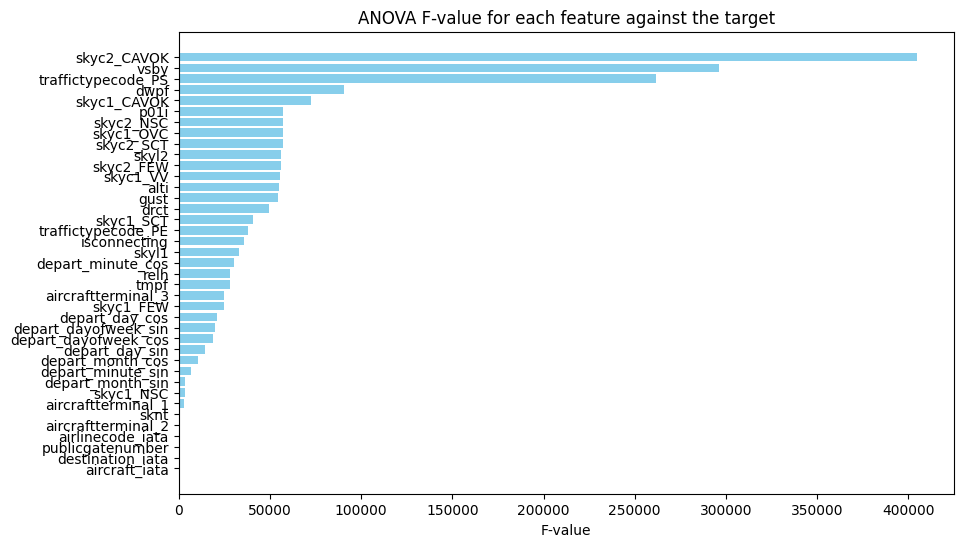

In [18]:
from scipy.stats import f_oneway

# Assuming y_train_cls is your target variable
anova_results = {}
for column in X_train.columns:
    # Perform ANOVA
    f_val, p_val = f_oneway(X_train[column], y_train_cls)
    anova_results[column] = f_val

# Sort the results by F-value
sorted_anova = sorted(anova_results.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_anova], [x[1] for x in sorted_anova], color='skyblue')
plt.xlabel('F-value')
plt.title('ANOVA F-value for each feature against the target')
plt.gca().invert_yaxis()
plt.show()

In [19]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# print('Original dataset shape %s' % Counter(y_train_cls))
# X_train, y_train_cls = smote.fit_resample(X_train, y_train_cls)
# print('Resampled dataset shape %s' % Counter(y_train_cls))


In [20]:
# X_full = pd.concat([X_train, X_test], axis=0)
# X_full

In [21]:
# neighbors = NearestNeighbors(n_neighbors=39*2)
# neighbors_fit = neighbors.fit(X_train)
# distances, indices = neighbors_fit.kneighbors(X_train)
# avg_distance = distances.mean(axis=1)
# plt.plot(np.sort(avg_distance))
# plt.show()

In [22]:
# sc = DBSCAN(eps=1, min_samples=39*2, algorithm='kd_tree')
# clusters = pd.DataFrame(sc.fit_predict(X_full), columns=['Cluster'])
# clusters['Cluster'].value_counts()

In [23]:
hdbscan_model = HDBSCAN(
    min_cluster_size=2000,      # Increase to avoid microclusters
    min_samples=5,              # Lower to reduce noise points
    cluster_selection_epsilon=0.6,  # Increase to reduce noise points
    cluster_selection_method='eom',  # 'eom' tends to produce more balanced clusters
    prediction_data=True
)
clusters_train = pd.DataFrame(hdbscan_model.fit_predict(X_train), columns=['Cluster'])
clusters_train['Cluster'].value_counts()

Cluster
 9    54518
 7    24496
 6    19205
-1    16906
 2    14796
 5     5425
 4     4974
 3     4161
 1     3079
 8     2656
 0     2424
Name: count, dtype: int64

In [24]:
from hdbscan import approximate_predict
clusters_test, _ = approximate_predict(hdbscan_model, X_test)

In [25]:
X_train['cluster'] = clusters_train['Cluster']
X_test['cluster'] = clusters_test

In [26]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

rf_models = {}
metrics = {}
all_y_true = []
all_y_pred = []
model_weights = {}

for cluster in np.unique(clusters_train):
    if cluster == -1:  # Ignore noise points (label -1)
        continue
    
    print(f'Cluster {cluster}')

    # Subset the training and test data for the cluster
    # Get cluster data
    X_cluster = X_train[X_train['cluster'] == cluster].drop(columns=['cluster'])
    y_cls_cluster = y_train_cls.loc[X_cluster.index]
    
    # Split into train and validation sets
    X_train_cluster, X_val_cluster, y_train_cls_cluster, y_val_cls_cluster = train_test_split(
        X_cluster, y_cls_cluster, test_size=0.2, random_state=42
    )
    X_test_cluster = X_test[X_test['cluster'] == cluster].drop(columns=['cluster'])
    y_test_cls_cluster = y_test_cls.loc[X_test_cluster.index]
    
    smote = SMOTE(random_state=42)
    print('Original dataset shape %s' % Counter(y_train_cls_cluster))
    X_train_cluster, y_train_cls_cluster = smote.fit_resample(X_train_cluster, y_train_cls_cluster)
    print('Resampled dataset shape %s' % Counter(y_train_cls_cluster))
    
    # Clean data - remove rows with NaN or infinite values
    mask_train = ~(np.isnan(X_train_cluster).any(axis=1) | np.isinf(X_train_cluster).any(axis=1))
    mask_test = ~(np.isnan(X_test_cluster).any(axis=1) | np.isinf(X_test_cluster).any(axis=1))
    
    X_train_cluster = X_train_cluster[mask_train]
    y_train_cls_cluster = y_train_cls_cluster[mask_train]
    X_test_cluster = X_test_cluster[mask_test]
    y_test_cls_cluster = y_test_cls_cluster[mask_test]

    # Define objective function for hyperopt
    param_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 5),
        'max_features': Categorical(['sqrt', 'log2']),
        'criterion': Categorical(['gini', 'entropy', 'log_loss'])
    }

    # Use Bayesian optimization for hyperparameter tuning
    bayes_cv = BayesSearchCV(
        estimator=RandomForestClassifier(),
        search_spaces=param_space,
        n_iter=10,
        cv=3,
        n_jobs=-1,
        scoring='f1'
    )
    bayes_cv.fit(X_train_cluster, y_train_cls_cluster)
    best_rf = bayes_cv.best_estimator_
    rf_models[cluster] = best_rf

    # Make predictions on the validation set and evaluate metrics
    y_val_pred = best_rf.predict(X_val_cluster)
    accuracy = accuracy_score(y_val_cls_cluster, y_val_pred)
    precision = precision_score(y_val_cls_cluster, y_val_pred)
    recall = recall_score(y_val_cls_cluster, y_val_pred)
    f1 = f1_score(y_val_cls_cluster, y_val_pred)
    model_weights[cluster] = f1  # Assign weight to the model based on validation F1 score

    # Print metrics
    print(f"Cluster {cluster} Validation Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("==========================================")

Cluster 0
Original dataset shape Counter({0: 1316, 1: 623})
Resampled dataset shape Counter({1: 1316, 0: 1316})
Cluster 0 Validation Metrics:
Accuracy: 0.7463917525773196
Precision: 0.59375
Recall: 0.6209150326797386
F1 Score: 0.6070287539936102
Cluster 1
Original dataset shape Counter({0: 1667, 1: 796})
Resampled dataset shape Counter({0: 1667, 1: 1667})
Cluster 1 Validation Metrics:
Accuracy: 0.6558441558441559
Precision: 0.45901639344262296
Recall: 0.4263959390862944
F1 Score: 0.4421052631578947
Cluster 2
Original dataset shape Counter({0: 9022, 1: 2814})
Resampled dataset shape Counter({1: 9022, 0: 9022})
Cluster 2 Validation Metrics:
Accuracy: 0.7375
Precision: 0.44571428571428573
Recall: 0.325
F1 Score: 0.3759036144578313
Cluster 3
Original dataset shape Counter({0: 2423, 1: 905})
Resampled dataset shape Counter({0: 2423, 1: 2423})
Cluster 3 Validation Metrics:
Accuracy: 0.723889555822329
Precision: 0.4717948717948718
Recall: 0.4200913242009132
F1 Score: 0.4444444444444444
Cluste

In [27]:
# Normalizing weights to sum to 1
total_weight = sum(model_weights.values())
model_weights = {cluster: weight / total_weight for cluster, weight in model_weights.items()}

In [28]:
# Make final predictions on the test set using weighted average
final_predictions = []
all_y_true = []
for idx in X_test.index:
    cluster = X_test.loc[idx, 'cluster']
    if cluster == -1:  # If it's noise, you can skip or handle it differently
        continue

    # Get predictions from all models, weighted by their respective scores
    weighted_sum = 0
    total_weight = 0
    for model_cluster, model in rf_models.items():
        weight = model_weights.get(model_cluster, 0)
        # Give highest weight to the model of the cluster that the test data belongs to
        if model_cluster == cluster:
            weight += 1  # Boost the weight of the corresponding cluster model
        prediction = model.predict(X_test.drop(columns=['cluster']).loc[[idx]])[0]
        weighted_sum += prediction * weight
        total_weight += weight

    # Final prediction is the weighted average
    final_prediction = round(weighted_sum / total_weight)
    final_predictions.append(final_prediction)
    all_y_true.append(y_test_cls.loc[idx])


In [29]:
# Calculate overall metrics
overall_accuracy = accuracy_score(all_y_true, final_predictions)
overall_precision = precision_score(all_y_true, final_predictions)
overall_recall = recall_score(all_y_true, final_predictions)
overall_f1 = f1_score(all_y_true, final_predictions)

print("\nOverall Metrics (Weighted Average Ensemble):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")


Overall Metrics (Weighted Average Ensemble):
Overall Accuracy: 0.7338771877781074
Overall Precision: 0.49978982765868013
Overall Recall: 0.39774754683318464
Overall F1 Score: 0.4429680223533064


: 

In [57]:
# from sklearn.manifold import TSNE
# # Perform t-SNE dimensionality reduction
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(X_full)


ValueError: 'c' argument has 152640 elements, which is inconsistent with 'x' and 'y' with size 190801.

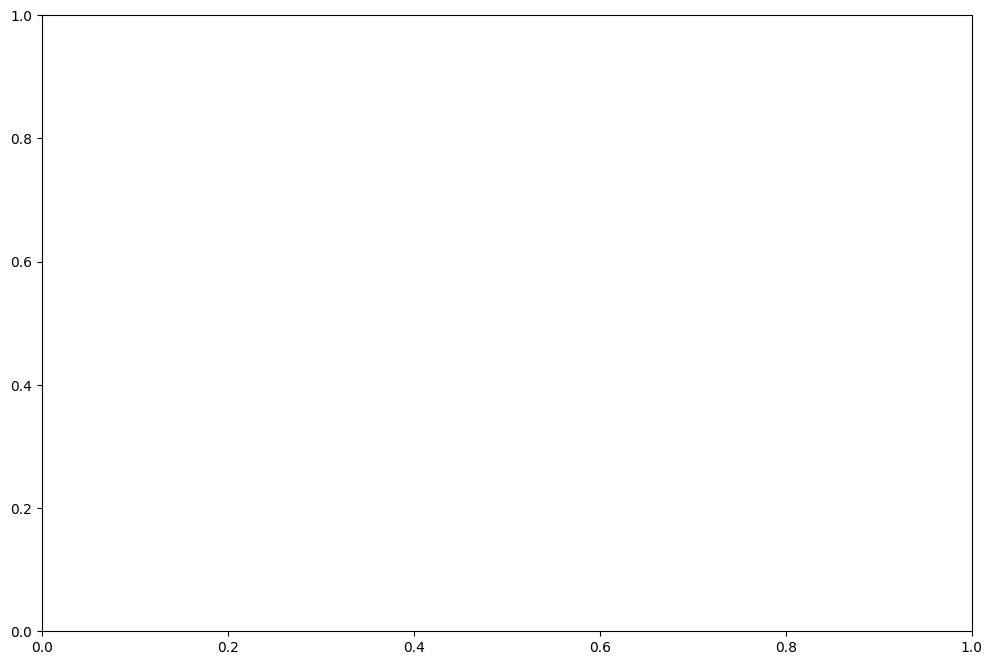

In [59]:
# # Create scatter plot
# plt.figure(figsize=(12, 8))
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_cls, cmap='tab20', alpha=0.6)
# plt.colorbar()
# plt.title('t-SNE visualization of HDBSCAN clusters')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.show()